In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import timm
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from helpers import plot

c:\Users\Karan Mathur\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = np.load('.//data.npy')
labels = np.load('.//labels.npy')

In [3]:
data.shape

(253, 224, 224, 3)

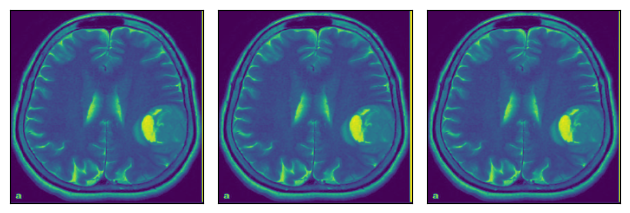

In [ ]:
ot = torch.from_numpy(data)
ot_chw = ot.permute(0, 3, 1, 2)
plot(ot_chw[-1])

The Data has been Loaded in Correctly

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, shuffle=True, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, random_state=42, stratify=y_train)

In [13]:
X_train = torch.from_numpy(X_train).permute(0, 3, 1, 2)
X_val = torch.from_numpy(X_val).permute(0, 3, 1, 2)
X_test = torch.from_numpy(X_test).permute(0, 3, 1, 2)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test) 

In [34]:
X_train = X_train.float()/255
X_val = X_val.float()/255
X_test  = X_test.float()/255

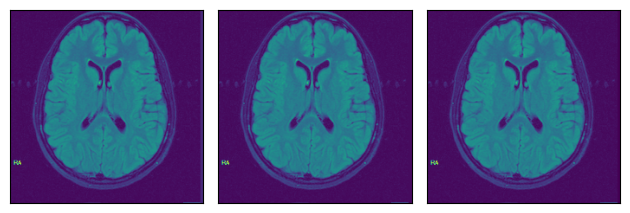

In [36]:
plot(X_train[0])

In [25]:
y_train = y_train.unsqueeze(1)
y_val = y_val.unsqueeze(1)
y_test = y_test.unsqueeze(1)

In [37]:
y_train = y_train.float()
y_val = y_val.float()
y_test = y_test.float()

In [46]:
X_train.shape

torch.Size([141, 3, 224, 224])

In [49]:
train_load = DataLoader(TensorDataset(X_train, y_train), batch_size=20)
val_load = DataLoader(TensorDataset(X_val, y_val), batch_size=8)
test_load = DataLoader(TensorDataset(X_test, y_test), batch_size=8)

In [78]:
train_transform = v2.Compose(
    [
        v2.RandomAffine(15),
        v2.ColorJitter(brightness=0.6, contrast=0.2)
    ]
)

In [75]:
X_aug = train_transform(X_train)

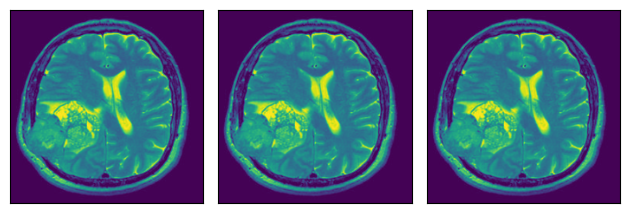

In [69]:
plot(X_train[-5])

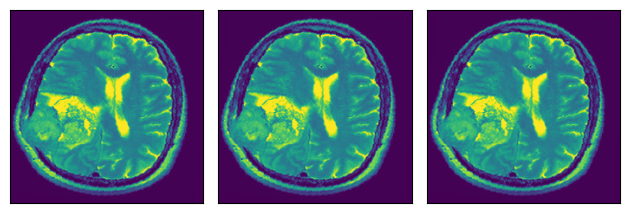

In [79]:
plot(X_aug[-5])

In [80]:
aug_load = DataLoader(TensorDataset(X_aug, y_train), batch_size=20, shuffle=True)

In [131]:
# Model
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = timm.create_model('convnextv2_nano.fcmae', pretrained=True, num_classes=1, )    # Taking this model as starting point, this can be replaced 
model = model.to(device)


In [86]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        #error calc
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [87]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (((torch.sigmoid(pred) > 0.5).float()) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:

loss_fn = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [133]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_load, model, loss_fn, optimizer)
    test(val_load, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.708149  [   20/  141]
loss: 0.712780  [   40/  141]
loss: 0.695808  [   60/  141]
loss: 0.690224  [   80/  141]
loss: 0.618683  [  100/  141]
loss: 0.635387  [  120/  141]
loss: 0.623792  [  140/  141]
loss: 0.950934  [    8/  141]
Test Error: 
 Accuracy: 60.4%, Avg loss: 0.643092 

Epoch 2
-------------------------------
loss: 0.688417  [   20/  141]
loss: 0.668286  [   40/  141]
loss: 0.551582  [   60/  141]
loss: 0.650653  [   80/  141]
loss: 0.546979  [  100/  141]
loss: 0.576659  [  120/  141]
loss: 0.563885  [  140/  141]
loss: 0.469454  [    8/  141]
Test Error: 
 Accuracy: 66.7%, Avg loss: 0.598274 

Epoch 3
-------------------------------
loss: 0.581690  [   20/  141]
loss: 0.623778  [   40/  141]
loss: 0.553904  [   60/  141]
loss: 0.586935  [   80/  141]
loss: 0.504732  [  100/  141]
loss: 0.507191  [  120/  141]
loss: 0.468215  [  140/  141]
loss: 0.253293  [    8/  141]
Test Error: 
 Accuracy: 72.9%, Avg loss: 0.529859 

Epoc

In [ ]:

loss_fn = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [135]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_load, model, loss_fn, optimizer)
    test(val_load, model, loss_fn)
    train(aug_load, model, loss_fn, optimizer)
    test(val_load, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.449447  [   20/  141]
loss: 0.497979  [   40/  141]
loss: 0.255645  [   60/  141]
loss: 0.352889  [   80/  141]
loss: 0.154986  [  100/  141]
loss: 0.324882  [  120/  141]
loss: 0.225628  [  140/  141]
loss: 0.049214  [    8/  141]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.355614 

loss: 0.372775  [   20/  141]
loss: 0.635165  [   40/  141]
loss: 0.448831  [   60/  141]
loss: 0.379630  [   80/  141]
loss: 0.472151  [  100/  141]
loss: 0.667747  [  120/  141]
loss: 0.280490  [  140/  141]
loss: 0.218493  [    8/  141]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.338405 

Epoch 2
-------------------------------
loss: 0.278086  [   20/  141]
loss: 0.430601  [   40/  141]
loss: 0.381889  [   60/  141]
loss: 0.405162  [   80/  141]
loss: 0.294693  [  100/  141]
loss: 0.255488  [  120/  141]
loss: 0.289760  [  140/  141]
loss: 0.046833  [    8/  141]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.347729 

loss: 0.378807  [   20/  141]
loss: 0.363390

In [ ]:

loss_fn = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [154]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(aug_load, model, loss_fn, optimizer)
    test(val_load, model, loss_fn)
    train(train_load, model, loss_fn, optimizer)
    test(val_load, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.040653  [   20/  141]
loss: 0.168345  [   40/  141]
loss: 0.117577  [   60/  141]
loss: 0.285669  [   80/  141]
loss: 0.120843  [  100/  141]
loss: 0.128559  [  120/  141]
loss: 0.211835  [  140/  141]
loss: 0.014074  [    8/  141]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.310900 

loss: 0.259996  [   20/  141]
loss: 0.305750  [   40/  141]
loss: 0.103205  [   60/  141]
loss: 0.077172  [   80/  141]
loss: 0.025142  [  100/  141]
loss: 0.060459  [  120/  141]
loss: 0.050180  [  140/  141]
loss: 0.016214  [    8/  141]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.275723 

Epoch 2
-------------------------------
loss: 0.137906  [   20/  141]
loss: 0.056248  [   40/  141]
loss: 0.037202  [   60/  141]
loss: 0.017673  [   80/  141]
loss: 0.057122  [  100/  141]
loss: 0.060766  [  120/  141]
loss: 0.084602  [  140/  141]
loss: 0.008488  [    8/  141]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.427697 

loss: 0.135590  [   20/  141]
loss: 0.316053

In [ ]:

loss_fn = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [158]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(aug_load, model, loss_fn, optimizer)
    test(val_load, model, loss_fn)
    train(train_load, model, loss_fn, optimizer)
    test(val_load, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.035210  [   20/  141]
loss: 0.071171  [   40/  141]
loss: 0.059165  [   60/  141]
loss: 0.022854  [   80/  141]
loss: 0.024428  [  100/  141]
loss: 0.019598  [  120/  141]
loss: 0.018169  [  140/  141]
loss: 0.012250  [    8/  141]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.303318 

loss: 0.027425  [   20/  141]
loss: 0.076408  [   40/  141]
loss: 0.021643  [   60/  141]
loss: 0.030056  [   80/  141]
loss: 0.012309  [  100/  141]
loss: 0.020191  [  120/  141]
loss: 0.016180  [  140/  141]
loss: 0.003264  [    8/  141]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.304144 

Epoch 2
-------------------------------
loss: 0.019295  [   20/  141]
loss: 0.019087  [   40/  141]
loss: 0.015700  [   60/  141]
loss: 0.031191  [   80/  141]
loss: 0.021740  [  100/  141]
loss: 0.013429  [  120/  141]
loss: 0.019209  [  140/  141]
loss: 0.015710  [    8/  141]
Test Error: 
 Accuracy: 89.6%, Avg loss: 0.300914 

loss: 0.017608  [   20/  141]
loss: 0.052444

In [162]:
torch.save(model.state_dict(), 'brain_tumor_94test.pth')


In [ ]:
model.load_state_dict(torch.load('brain_tumor_94test.pth', weights_only=True))

<All keys matched successfully>

In [159]:
test(test_load, model, loss_fn)

Test Error: 
 Accuracy: 93.8%, Avg loss: 0.208977 

